# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
# from tensorflow import keras
print(tf.__version__)
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

2021-10-13 23:41:40.430252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-13 23:41:40.430296: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.6.0


## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

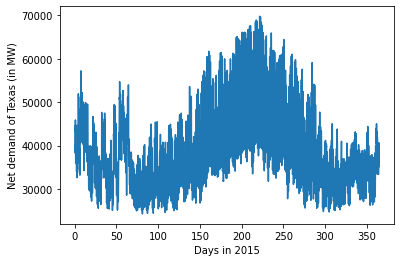

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (10 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**It gets very hot it summer so people turn on their air conditioners all around the same time creating the peak we see in the graph**


#### Q2. How does day of week affect the load profiles? It seems as though the weekdays have higher surges of power usage due to the the fact that its the work week.

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


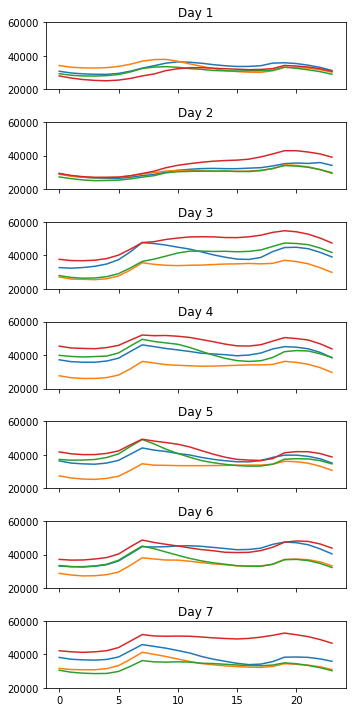

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Can you find any discernible change in the load profiles of different days of the week? Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? 


**The is less divergence between the graphs and the all follow a similar flow with a peak around the 3:00 PM mark**

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


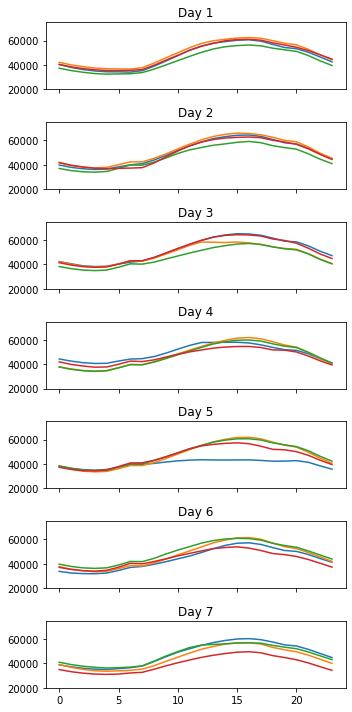

In [5]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 227
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [6]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [7]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

**Question (25 points). Insert code to design the NN and its optimizer (use the relu function)** 

In [8]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=(nDimX), name="input") #insert code
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_1", use_bias=True, bias_initializer='zeros')(inputs)#insert code
outputs = keras.layers.Dense(nDimY, name="output")(nn_layer) #insert code

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.01),#insert code ,
    loss= keras.losses.MeanSquaredError()#insert code 
)


2021-10-13 23:41:44.709514: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-13 23:41:44.709541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zookeeper): /proc/driver/nvidia/version does not exist
2021-10-13 23:41:44.709777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



### Train the neural network via Keras.

Create the training module for the NN. 

Keras is a user-friendly framework to define, train and test neural networks. Check their page out for more details. https://keras.io/ 

Feed the training data in batches of size 'batchSize'.Usually, going through the training data once does not train your NN. You train over the same data multiple times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn a material by reading through it once!

**Question (20 points). Insert code to define the training module**

In [9]:
batchSize = 30#
nEpochs = 3000#

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
    trainX,
    trainY,
    batch_size=batchSize,
    epochs=nEpochs
)
print (trainY.shape)
print (trainX.shape)


2021-10-13 23:41:44.836694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Fit model on training data
Epoch 1/3000
10/10 [==============================] - 0s 2ms/step - loss: 1651262976.0000
Epoch 2/3000
10/10 [==============================] - 0s 2ms/step - loss: 1649653888.0000
Epoch 3/3000
10/10 [==============================] - 0s 2ms/step - loss: 1647553536.0000
Epoch 4/3000
10/10 [==============================] - 0s 2ms/step - loss: 1645308544.0000
Epoch 5/3000
10/10 [==============================] - 0s 2ms/step - loss: 1643002496.0000
Epoch 6/3000
10/10 [==============================] - 0s 2ms/step - loss: 1640644352.0000
Epoch 7/3000
10/10 [==============================] - 0s 2ms/step - loss: 1638264704.0000
Epoch 8/3000
10/10 [==============================] - 0s 2ms/step - loss: 1635841536.0000
Epoch 9/3000
10/10 [==============================] - 0s 2ms/step - loss: 1633430400.0000
Epoch 10/3000
10/10 [==============================] - 0s 2ms/step - loss: 1630978048.0000
Epoch 11/3000
10/10 [==============================] - 0s 2ms/step - los

### Let us visualize the results.

**Question (5 points). Usine the NN to predict on test data**


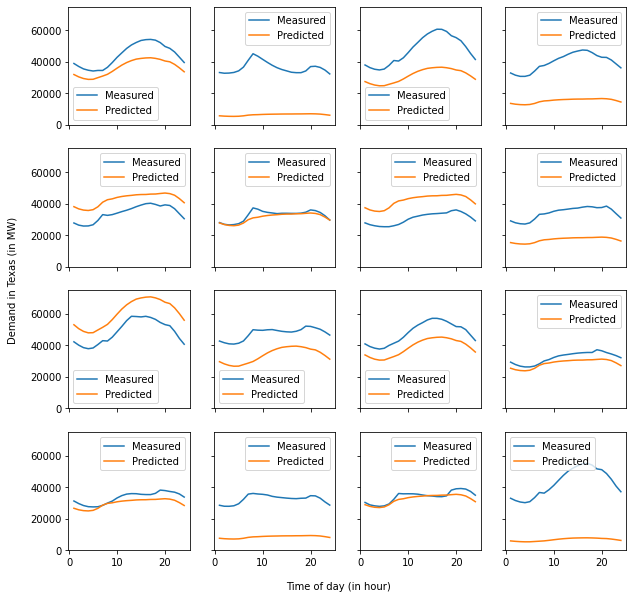

In [10]:
# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)# insert code

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

**Question (10 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**As the number of epochs increases I find that the training time takes exceedingly longer and but your code starts to fit much much better. The good thing is that the fitting in this situation doesn't resemble overfitting because we have gone out of our way to seperate our test dataset from that of the training so we know that its not memorizing the data. As an engineer I find that I like the 1000-5000 range because our model fits very accurately and I happen to have a cuda enabled device so I have been able to optimize the code for my machine to run faster. Also It makes no sense to go higher than this value as there is no real benefit to training the model so much on the same data set.**

**Question (15 points).** Fix the number of epochs to your favorite one. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. 

**Your answer (comments here, code below). The accuracy is significantly better using multiple layers with relatively little increase in training time. NOTE: using a Adam optimizer is better. I also added two more layers instead of one to make the difference more pronounced.|**

Fit model on training data
Epoch 1/3000
10/10 [==============================] - 0s 2ms/step - loss: 1648695168.0000
Epoch 2/3000
10/10 [==============================] - 0s 2ms/step - loss: 1619770880.0000
Epoch 3/3000
10/10 [==============================] - 0s 2ms/step - loss: 1561018880.0000
Epoch 4/3000
10/10 [==============================] - 0s 2ms/step - loss: 1483545984.0000
Epoch 5/3000
10/10 [==============================] - 0s 2ms/step - loss: 1396017536.0000
Epoch 6/3000
10/10 [==============================] - 0s 2ms/step - loss: 1300788608.0000
Epoch 7/3000
10/10 [==============================] - 0s 2ms/step - loss: 1203150464.0000
Epoch 8/3000
10/10 [==============================] - 0s 2ms/step - loss: 1105057664.0000
Epoch 9/3000
10/10 [==============================] - 0s 2ms/step - loss: 1009627712.0000
Epoch 10/3000
10/10 [==============================] - 0s 2ms/step - loss: 918140864.0000
Epoch 11/3000
10/10 [==============================] - 0s 2ms/step - loss

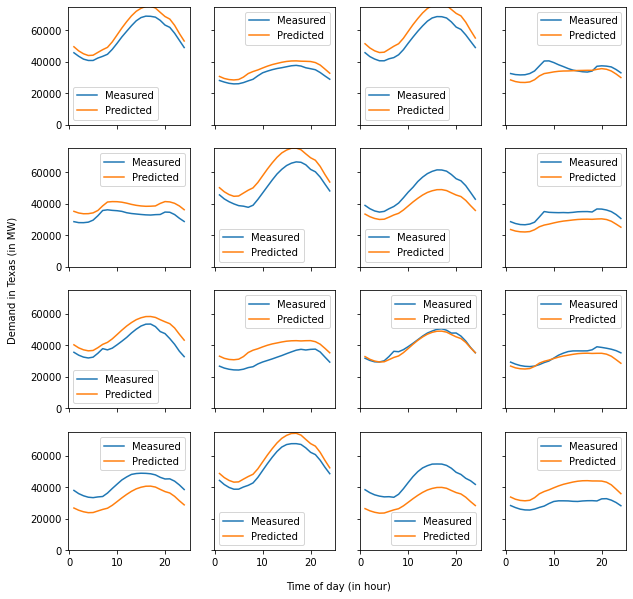

In [11]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=(nDimX), name="input") #insert code
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_1", use_bias=True, bias_initializer='zeros')(inputs)#insert code
nn_Layer = keras.layers.Dense(nHidden, activation="relu", name="dense_2", use_bias=True, bias_initializer='zeros')(nn_layer)#insert code
outputs = keras.layers.Dense(nDimY, name="output")(nn_Layer) #insert code

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.01),#insert code ,
    loss= keras.losses.MeanSquaredError()#insert code 
)

batchSize = 30#
nEpochs = 3000#

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
    trainX,
    trainY,
    batch_size=batchSize,
    epochs=nEpochs
)
print (trainY.shape)
print (trainX.shape)# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)# insert code

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)# insert code

### The effect of wind energy (bonus).

In [12]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
...,...,...,...,...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,3825,16170,9.6,23.7,484.0,14.5
8756,12/31/15 20:00,31-Dec,38737,4626,16170,11.9,28.6,801.0,20.9
8757,12/31/15 21:00,31-Dec,37588,4958,16170,13.2,30.7,332.0,7.2
8758,12/31/15 22:00,31-Dec,36356,4699,16170,12.9,29.1,-259.0,-5.2


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why?

**Your answer (comments here, code below).**